# Глава 10 (Иванов Илья, группа 3530901/70203)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

PI2 = 2 * np.pi

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

## Упражнение 10.1.
In Section 10.4 I describe convolution as the sum of shifted, scaled copies of a signal. Strictly speaking, this operation is linear convolution, which does not assume that the signal is periodic.

But in Section 10.3, when we multiply the DFT of the signal by the transfer function, that operation corresponds to circular convolution, which assumes that the signal is periodic. As a result, you might notice that the output contains an extra note at the beginning, which wraps around from the end.

Fortunately, there is a standard solution to this problem. If you add enough zeros to the end of the signal before computing the DFT, you can avoid wrap-around and compute a linear convolution.

Modify the example in `chap10.ipynb` and confirm that zero-padding eliminates the extra note at the beginning of the output.


Урежем оба сигнала до $2^{16}$ элементов, а затем дополним их нулями до $2^{17}$ элементов. Использование степеней двойки делает алгоритм БПФ наиболее эффективным.

Получим импульсную характеристику:

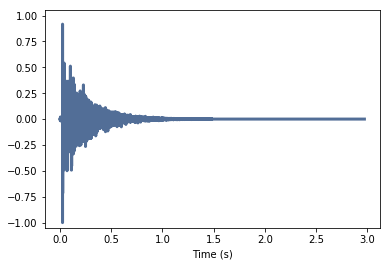

In [2]:
response = thinkdsp.read_wave('180960__kleeb__gunshot.wav')

start = 0.12
response = response.segment(start=start)
response.shift(-start)

response.truncate(2**16)
response.zero_pad(2**17)

response.normalize()
response.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Её спектр:

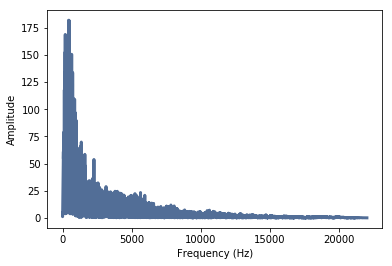

In [3]:
transfer = response.make_spectrum()
transfer.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude')

Рассматриваемый сигнал:

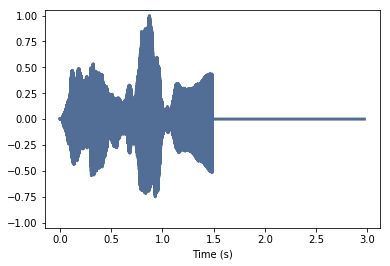

In [4]:
violin = thinkdsp.read_wave('92002__jcveliz__violin-origional.wav')

start = 0.11
violin = violin.segment(start=start)
violin.shift(-start)

violin.truncate(2**16)
violin.zero_pad(2**17)

violin.normalize()
violin.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Его спектр:

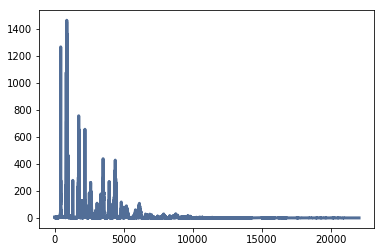

In [5]:
spectrum = violin.make_spectrum()
spectrum.plot()

Умножим ДПФ сигнала на передаточную функцию, после чего преобразуем обратно в волну:

In [6]:
output = (spectrum * transfer).make_wave()
output.normalize()

По внешнему виду результата можно сказать, что эффекта "заворота" удалось избежать:

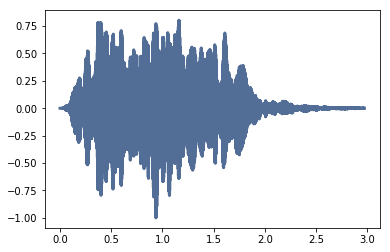

In [7]:
output.plot()

Лишней ноты в начале не слышно:

In [8]:
output.make_audio()

С помощью `np.convolve` и `scipy.signal.fftconvolve` мы должны получить те же результаты.

Избавимся от заполнения нулями:

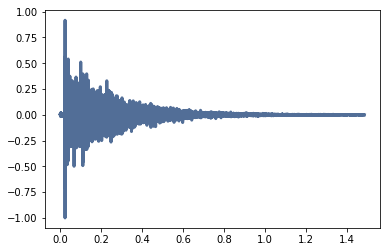

In [9]:
response.truncate(2**16)
response.plot()

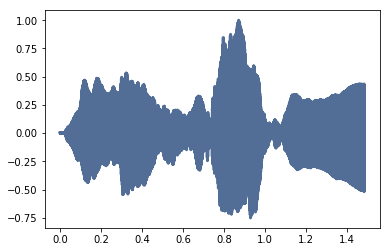

In [10]:
violin.truncate(2**16)
violin.plot()

Используем `np.convolve`:

In [11]:
output2 = violin.convolve(response)

Результаты выглядят одинаково:

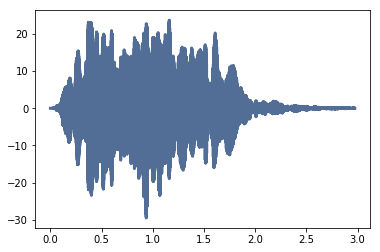

In [12]:
output2.plot()

И звучат одинаково:

In [13]:
output2.make_audio()

Но они не совсем одинаковой длины:

In [14]:
len(output), len(output2)

(131072, 131071)

`scipy.signal.fftconvolve` делает то же самое, но, как следует из названия, он использует БПФ, поэтому он значительно быстрее:

In [15]:
import scipy.signal
ys = scipy.signal.fftconvolve(violin.ys, response.ys)
output3 = thinkdsp.Wave(ys, framerate=violin.framerate)

Результаты выглядят одинаково:

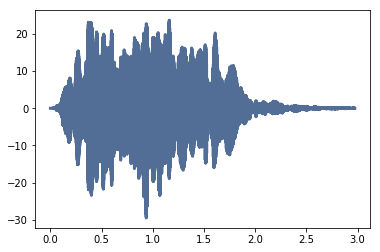

In [16]:
output3.plot()

И звучат одинаково:

In [17]:
output3.make_audio()

И, в пределах ошибки представления чисел с плавающей запятой, они одинаковы:

In [18]:
output2.max_diff(output3)

2.842170943040401e-14

## Упражнение 10.2.
The Open AIR library provides a “centralized... on-line resource for anyone interested in auralization and acoustical impulse response data” (http://www.openairlib.net). Browse their collection of impulse response data and download one that sounds interesting. Find a short recording that has the same sample rate as the impulse response you downloaded.

Simulate the sound of your recording in the space where the impulse response was measured, computed two way: by convolving the recording with the impulse response and by computing the filter that corresponds to the impulse response and multiplying by the DFT of the recording.

Я выбрал импульсную характеристику церкви Святой Маргариты (https://openairlib.net/?page_id=702):

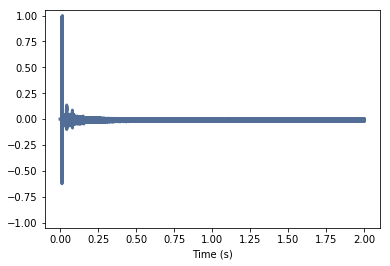

In [19]:
response = thinkdsp.read_wave('5_st250_w.wav')

start = 0
duration = 2
response = response.segment(duration=duration)
response.shift(-start)

response.normalize()
response.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Прослушаем её:

In [20]:
response.make_audio()

ДПФ импульсной характеристики является передаточной функцией:

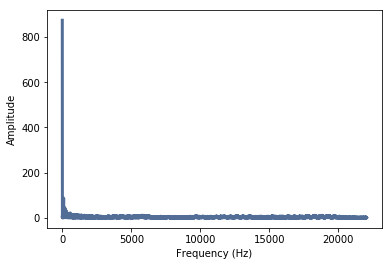

In [21]:
transfer = response.make_spectrum()
transfer.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude')

Передаточная функция в двойном логарифмическом масштабе:

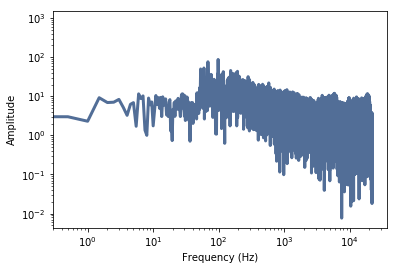

In [22]:
transfer.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='Amplitude', xscale='log', yscale='log')

Теперь мы можем смоделировать, как будет звучать запись, если она будет сделана в церкви Святой Маргариты. Возьмём запись скрипки, которую мы использовали ранее:

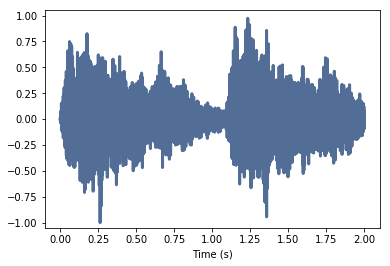

In [23]:
wave = thinkdsp.read_wave('170255__dublie__trumpet.wav')

start = 0.0
wave = wave.segment(start=start)
wave.shift(-start)
wave.truncate(len(response))
wave.normalize()
wave.plot()
thinkplot.config(xlabel='Time (s)', ylim=[-1.05, 1.05])

Прослушаем её до трансформации:

In [24]:
wave.make_audio()

Вычислим её ДПФ:

In [25]:
spectrum = wave.make_spectrum()

Запись скрипки была урезана до длины импульсной характеристики.

In [26]:
len(spectrum.hs), len(transfer.hs)

(44101, 44101)

In [27]:
spectrum.fs

array([    0. ,     0.5,     1. , ..., 22049. , 22049.5, 22050. ])

In [28]:
transfer.fs

array([    0. ,     0.5,     1. , ..., 22049. , 22049.5, 22050. ])

Умножим в частотной области, а затем преобразуем обратно во временную область:

In [29]:
output = (spectrum * transfer).make_wave()
output.normalize()

Сравним оригинальную запись с преобразованной:

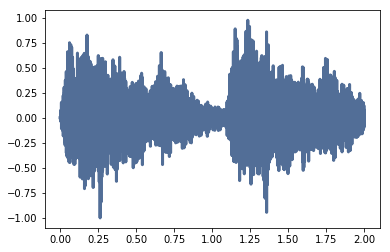

In [30]:
wave.plot()

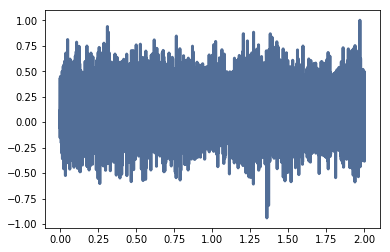

In [31]:
output.plot()

Прослушаем преобразованную запись:

In [32]:
output.make_audio()

Преобразуем исходную запись, используя свёртку:

In [33]:
convolved2 = wave.convolve(response)
convolved2.normalize()
convolved2.make_audio()